<a href="https://colab.research.google.com/github/BRIJNANDA1979/BIGEARTHNET/blob/main/BigEarthNet_k_means_Unsupervised_classiffication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# https://www.acgeospatial.co.uk/k-means-sentinel-2-python/

In [27]:
import numpy as np
from sklearn import cluster
from osgeo import gdal, gdal_array
import matplotlib.pyplot as plt

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

In [28]:
# Read in raster image
img_ds = gdal.Open('/content/drive/MyDrive/BigEathNet30_Geotif/S2A_MSIL2A_20170613T101031_0_45.tif', gdal.GA_ReadOnly)

band = img_ds.GetRasterBand(2)

img = band.ReadAsArray()

In [29]:
print(img.shape)

(20, 20)


In [30]:
#To use the classifier we need to reshape this array. For the classifier to accept the data we need to use the command .reshape(-1,1) and that means we want to flatten the data into the rows (unknown length) and keep the coloumns as 1. So our resulting array takes the form (rows, 1).

X = img.reshape((-1,1))

In [31]:
print(X.shape)

(400, 1)


In [32]:
k_means = cluster.KMeans(n_clusters=80)
k_means.fit(X)

X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(img.shape)

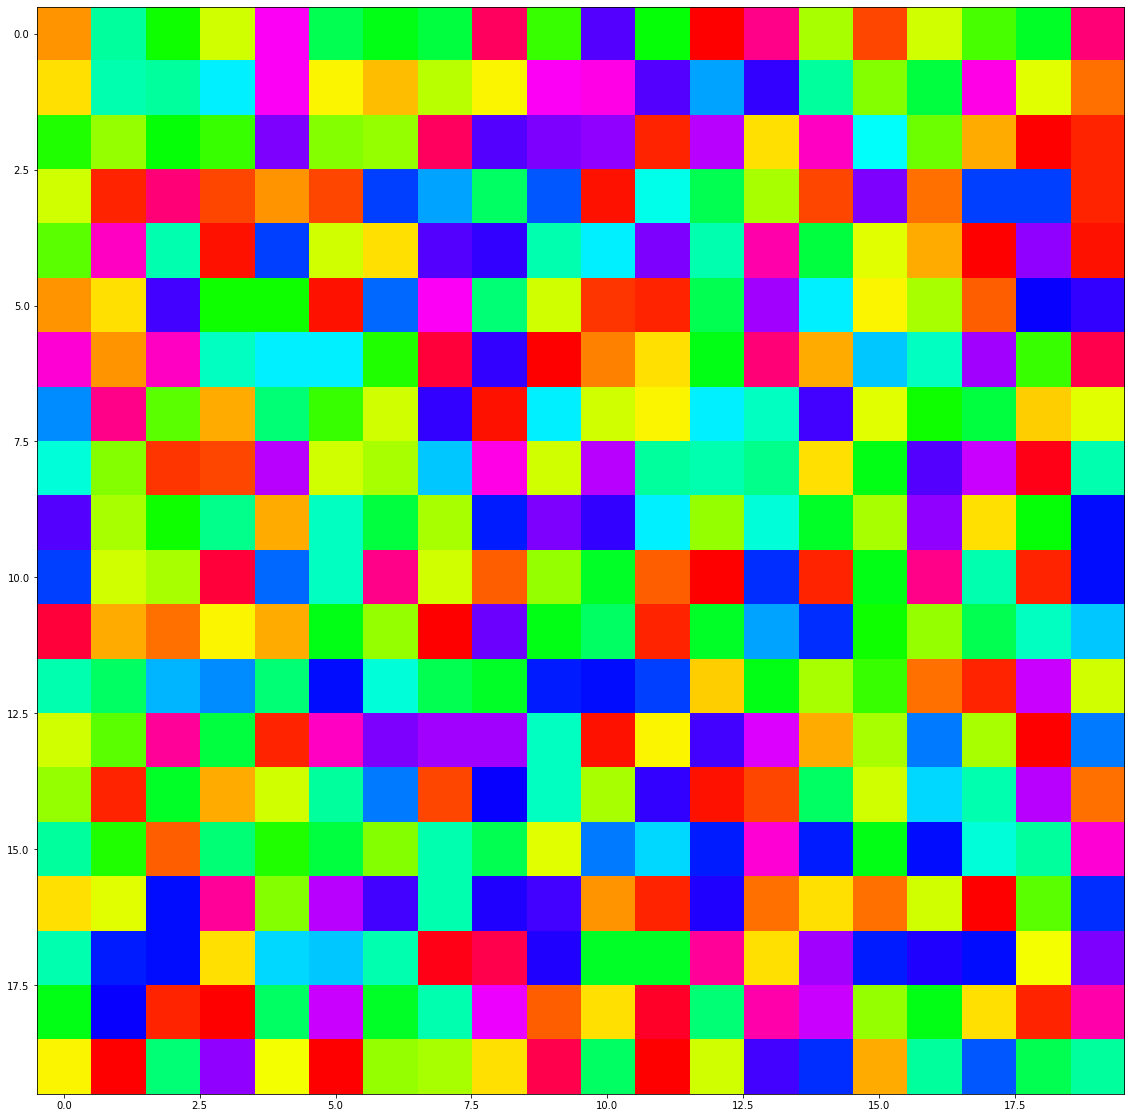

In [33]:
plt.figure(figsize=(20,20))
plt.imshow(X_cluster, cmap="hsv")
plt.show()

In [34]:
# Sentinel 2 has 13 spectral bands, giving us another 12 inputs into our classifer. It would seem a waste to not utilise all of these. They do have a variety of spatial resolutions but numpy can handle that. Let’s reload our image and this time read all the bands into an array:

In [35]:
# Read in raster image
img_ds = gdal.Open('/content/drive/MyDrive/BigEathNet30_Geotif/S2A_MSIL2A_20170613T101031_0_53.tif', gdal.GA_ReadOnly)


img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))

for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()

In [36]:
new_shape = (img.shape[0] * img.shape[1], img.shape[2])

In [37]:
X = img[:, :, :13].reshape(new_shape)

In [38]:
k_means = cluster.KMeans(n_clusters=16)
k_means.fit(X)

X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(img[:, :, 0].shape)

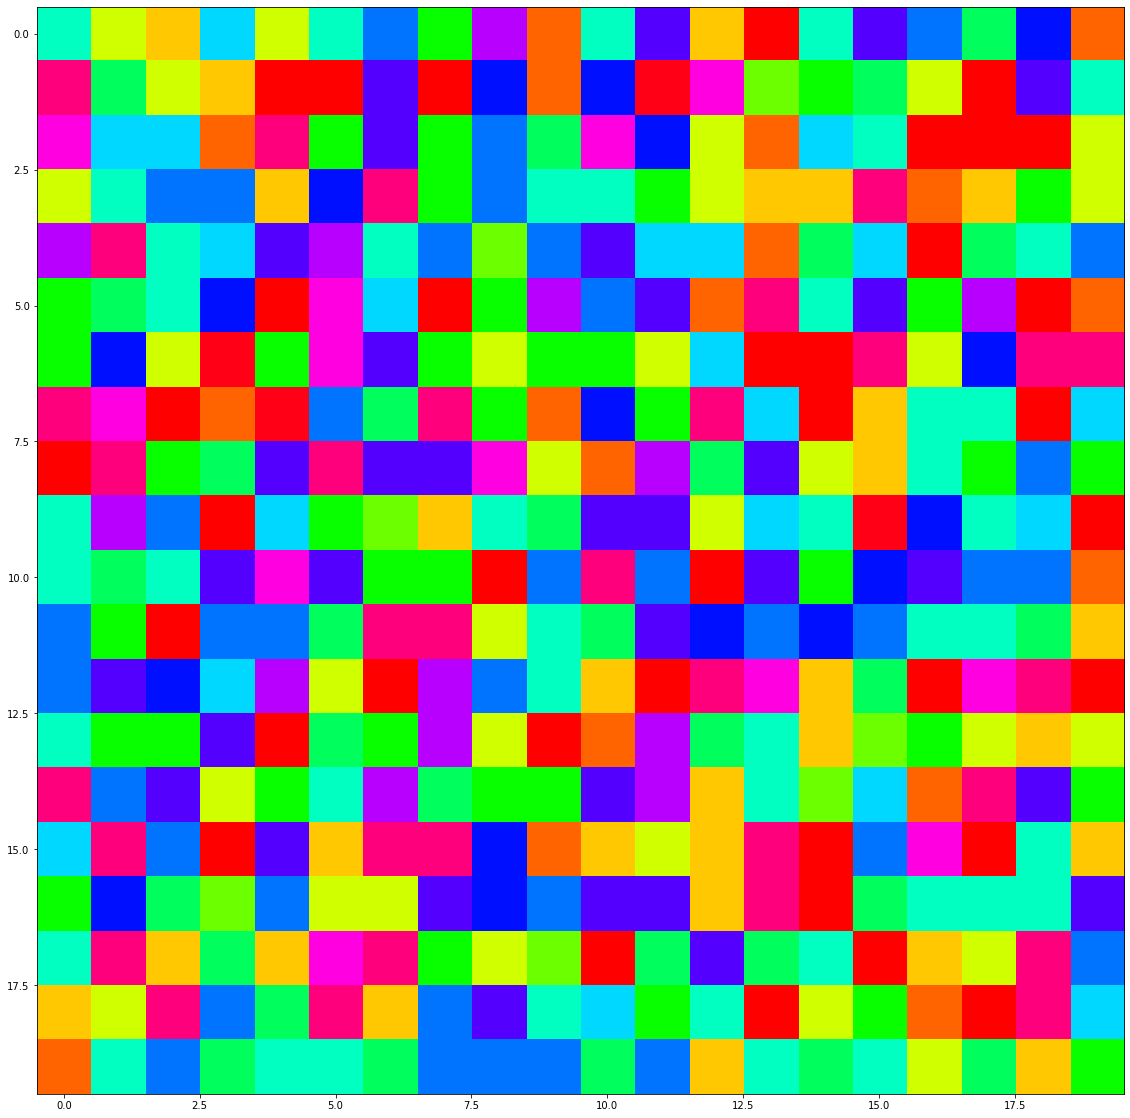

In [39]:
plt.figure(figsize=(20,20))
plt.imshow(X_cluster, cmap="hsv")

plt.show()

In [40]:
# The last step is to write the classification result to a single band raster image (line 10) before calling FlushCache() to remove from memory and delete the data.

In [41]:
ds = gdal.Open("/content/drive/MyDrive/BigEathNet30_Geotif/S2A_MSIL2A_20170613T101031_0_53.tif")
band = ds.GetRasterBand(2)
arr = band.ReadAsArray()
[cols, rows] = arr.shape

format = "GTiff"
driver = gdal.GetDriverByName(format)


outDataRaster = driver.Create("/content/drive/MyDrive/k_means.gtif", rows, cols, 1, gdal.GDT_Byte)
outDataRaster.SetGeoTransform(ds.GetGeoTransform())##sets same geotransform as input
outDataRaster.SetProjection(ds.GetProjection())##sets same projection as input


outDataRaster.GetRasterBand(1).WriteArray(X_cluster)

outDataRaster.FlushCache() ## remove from memory
del outDataRaster ## delete the data (not the actual geotiff)


In [43]:
#That’s it. You should be able to load this classification raster into a GIS package now and compare directly with your input satellite image